In [169]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
import re, unicodedata, datetime
from IPython.display import HTML

import bokeh.plotting as bk
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import brewer
from bokeh.io import output_notebook
#import matplotlib.pyplot as plt
#%matplotlib inline

pd.set_option('display.max_rows', 500)

## Primero, cargamos la lista de Instituciones de Educacion Superior del Mineduc

In [2]:
mineduc_file='data/Mineduc Listado IES Vigentes 05-2016.csv'
mineduc=pd.read_csv(mineduc_file, header=0, sep=',')
mineduc['fecha_reconocimiento']=pd.to_datetime(mineduc['fecha_reconocimiento'])
mineduc['año_reconocimiento']=mineduc['fecha_reconocimiento'].dt.year
mineduc.head()

,tipo,n_registro,nombre,tipo_reconocimiento,documento_reconocimiento,n_documento_reconocimiento,fecha_reconocimiento,regimen_funcionamiento,año_reconocimiento
0,C,1,Universidad Gabriela Mistral,Autorización de Funcionamiento,Certificado,S/N,1981-01-12,Autónoma,1981
1,C,2,Universidad Finis Terrae,Autorización de Funcionamiento,Certificado,S/N,1982-02-01,Autónoma,1982
2,C,3,Universidad Diego Portales,Autorización de Funcionamiento,Certificado,1082,1982-12-21,Autónoma,1982
3,C,4,Universidad Central de Chile,Autorización de Funcionamiento,Certificado,125,1983-02-24,Autónoma,1983
4,C,10,Universidad Bolivariana,Autorización de Funcionamiento,Certificado,584,1988-06-21,Autónoma,1988


In [3]:
list(mineduc['nombre'])

['Universidad Gabriela Mistral',
 'Universidad Finis Terrae',
 'Universidad Diego Portales',
 'Universidad Central de Chile',
 'Universidad Bolivariana',
 'Universidad Pedro de Valdivia',
 'Universidad Mayor',
 'Universidad Academia de Humanismo Cristiano',
 'Universidad Santo Tomás',
 'Universidad La República',
 'Universidad Sek',
 'Universidad de Las Américas',
 'Universidad Andrés Bello',
 'Universidad de Viña del Mar',
 'Universidad Adolfo Ibañez',
 'Universidad Iberoamericana de Ciencias y Tecnología, UNICIT',
 'Universidad de Artes, Ciencias y Comunicación - UNIACC',
 'Universidad UCINF',
 'Universidad Autónoma de Chile',
 'Universidad de Los Andes',
 'Universidad Adventista de Chile',
 'Universidad San Sebastián',
 'Universidad de Arte y Ciencias Sociales ARCIS',
 'Universidad Católica Cardenal Raúl Silva Henríquez',
 'Universidad del Desarrollo',
 'Universidad de Aconcagua',
 'Universidad del Pacífico',
 'Universidad Los Leones',
 "Universidad Bernardo O'Higgins",
 'Universida

In [4]:
for i in range(len(mineduc.index)):
    old=mineduc.loc[i,'nombre']
    new=re.sub(" ?\(\+\+\) ?| ?\(\*.*\) ?","", old)
    print("OLD: ", old)
    print("NEW: ", new)
    mineduc.loc[i,'nombre']=new

OLD:  Universidad Gabriela Mistral
NEW:  Universidad Gabriela Mistral
OLD:  Universidad Finis Terrae
NEW:  Universidad Finis Terrae
OLD:  Universidad Diego Portales
NEW:  Universidad Diego Portales
OLD:  Universidad Central de Chile
NEW:  Universidad Central de Chile
OLD:  Universidad Bolivariana
NEW:  Universidad Bolivariana
OLD:  Universidad Pedro de Valdivia
NEW:  Universidad Pedro de Valdivia
OLD:  Universidad Mayor
NEW:  Universidad Mayor
OLD:  Universidad Academia de Humanismo Cristiano
NEW:  Universidad Academia de Humanismo Cristiano
OLD:  Universidad Santo Tomás
NEW:  Universidad Santo Tomás
OLD:  Universidad La República
NEW:  Universidad La República
OLD:  Universidad Sek
NEW:  Universidad Sek
OLD:  Universidad de Las Américas
NEW:  Universidad de Las Américas
OLD:  Universidad Andrés Bello
NEW:  Universidad Andrés Bello
OLD:  Universidad de Viña del Mar
NEW:  Universidad de Viña del Mar
OLD:  Universidad Adolfo Ibañez
NEW:  Universidad Adolfo Ibañez
OLD:  Universidad Iberoa

In [5]:
mineduc=mineduc.sort_values('fecha_reconocimiento').reset_index(drop=True)
mineduc.head()

,tipo,n_registro,nombre,tipo_reconocimiento,documento_reconocimiento,n_documento_reconocimiento,fecha_reconocimiento,regimen_funcionamiento,año_reconocimiento
0,A,1,Universidad de Chile,Creación,Ley,s/n,1842-11-19,Autónoma,1842
1,B,1,Pontificia Universidad Católica de Chile,Fundación,Decreto,S/N,1888-06-21,Autónoma,1888
2,B,2,Universidad de Concepción,Fundación,Decreto Supremo,1038,1920-05-14,Autónoma,1920
3,B,3,Universidad Técnica Federico Santa María,Fundación,Decreto Supremo,996,1926-04-27,Autónoma,1926
4,B,4,Pontificia Universidad Católica de Valparaíso,Creación,Decreto,s/n,1928-03-15,Autónoma,1928


## Segundo, cargamos la lista de proyectos FONDECYT regular

In [76]:
fondecyt_2010=pd.read_csv('data/fondecyt regular 2010.csv', header=0, sep=',')
fondecyt_2011=pd.read_csv('data/fondecyt regular 2011.csv', header=0, sep=',')
fondecyt_2012=pd.read_csv('data/fondecyt regular 2012.csv', header=0, sep=',')
fondecyt_2013=pd.read_csv('data/fondecyt regular 2013.csv', header=0, sep=',')
fondecyt_2014=pd.read_csv('data/fondecyt regular 2014.csv', header=0, sep=',')
fondecyt_2015=pd.read_csv('data/fondecyt regular 2015.csv', header=0, sep=',')
fondecyt_2016=pd.read_csv('data/fondecyt regular 2016.csv', header=0, sep=',')

In [79]:
fondecyt=pd.concat([fondecyt_2010,fondecyt_2011,fondecyt_2012,fondecyt_2013,fondecyt_2014,fondecyt_2015,fondecyt_2016]).reset_index(drop=True)
for i in range(len(fondecyt.index)):
    name=(fondecyt.loc[i,'nombre']).upper()
    name=name.replace("UNIV.","UNIVERSIDAD").replace("PONT.","PONTIFICIA").replace("CS.","CIENCIAS").replace("TEC.","TECNOLOGIA")
    name=name.replace("INTERNACIONAL SEK","SEK").replace("UNIVERSIDAD CIENCIAS DE LA INFORMATICA","UNIVERSIDAD UCINF")
    fondecyt.loc[i,'nombre']=name.capitalize()

fondecyt.head()

,nombre,n_concursados,n_aprobados,año
0,Universidad de chile,204,86,2010
1,Pontificia universidad catolica de chile,180,100,2010
2,Universidad de concepcion,95,41,2010
3,Universidad austral de chile,48,25,2010
4,Universidad de santiago de chile,62,21,2010


In [80]:
for i in range(len(fondecyt.index)):
    if fondecyt.ix[i,'nombre'] != 'Otras universidades':
        d = mineduc.apply(lambda x: fuzz.ratio(x['nombre'].upper(), fondecyt.ix[i, 'nombre'].upper()), axis=1)
        if d.max()<85:
            print("WARNING - Fuzz ratio lower than 85")
            print('Fondecyt name: ', fondecyt.ix[i,'nombre'])
            print('Mineduc name: ', mineduc.ix[d.idxmax(), 'nombre'])
        fondecyt.ix[i,'nombre']=mineduc.ix[d.idxmax(), 'nombre']

fondecyt.head()

,nombre,n_concursados,n_aprobados,año
0,Universidad de Chile,204,86,2010
1,Pontificia Universidad Católica de Chile,180,100,2010
2,Universidad de Concepción,95,41,2010
3,Universidad Austral de Chile,48,25,2010
4,Universidad de Santiago de Chile,62,21,2010


In [81]:
fondecyt_university=fondecyt.groupby(['nombre']).sum().sort_values('n_aprobados', ascending=False).reset_index()[['nombre','n_concursados','n_aprobados']]
fondecyt_university.head()

,nombre,n_concursados,n_aprobados
0,Universidad de Chile,1765,854
1,Pontificia Universidad Católica de Chile,1361,746
2,Universidad de Concepción,754,330
3,Universidad de Santiago de Chile,454,194
4,Universidad Austral de Chile,339,166


In [82]:
fondecyt['tasa_aprobacion']=np.round(fondecyt['n_aprobados']/fondecyt['n_concursados']*100,decimals=1)
fondecyt_pivot = pd.pivot_table(fondecyt,values=['n_concursados','n_aprobados','tasa_aprobacion'],index=['nombre'],columns=['año'],aggfunc=np.sum,margins=True)
fondecyt_pivot.sort_values(by=('n_aprobados','All'), ascending=False, inplace=True)
fondecyt_pivot.ix[:,'tasa_aprobacion']=np.round(fondecyt_pivot.ix[:,'n_aprobados'].values/fondecyt_pivot.ix[:,'n_concursados'].values*100, decimals=1)
fondecyt_stack=fondecyt_pivot.stack('año')[['n_concursados','n_aprobados','tasa_aprobacion']].fillna(0)
fondecyt_stack

n_concursados  \
nombre                                             año                   
All                                                2010          970.0   
                                                   2011          976.0   
                                                   2012         1115.0   
                                                   2013         1097.0   
                                                   2014         1250.0   
                                                   2015         1453.0   
                                                   2016         1698.0   
                                                   All          8559.0   
Universidad de Chile                               2010          204.0   
                                                   2011          219.0   
                                                   2012          251.0   
                                                   2013          211.0   
                                                   2014          253.0   
                                                   2015          289.0   
                                                   2016          338.0   
                                                   All          1765.0   
Pontificia Universidad Católica de Chile           2010          180.0   
                                                   2011          160.0   
                                                   2012          142.0   
                                                   2013          184.0   
                                                   2014          202.0   
                                                   2015          225.0   
                                                   2016          268.0   
                                                   All          1361.0   
Universidad de Concepción                          2010           95.0   
                                                   2011           93.0   
                                                   2012           97.0   
                                                   2013          105.0   
                                                   2014          108.0   
                                                   2015          112.0   
                                                   2016          144.0   
                                                   All           754.0   
Universidad de Santiago de Chile                   2010           62.0   
                                                   2011           66.0   
                                                   2012           84.0   
                                                   2013           75.0   
                                                   2014           74.0   
                                                   2015            1.0   
                                                   2016           92.0   
                                                   All           454.0   
Universidad Austral de Chile                       2010           48.0   
                                                   2011           47.0   
                                                   2012           44.0   
                                                   2013           58.0   
                                                   2014           49.0   
                                                   2015           22.0   
                                                   2016           71.0   
                                                   All           339.0   
Pontificia Universidad Católica de Valparaíso      2010           53.0   
                                                   2011           54.0   
                                                   2012           56.0   
                                                   2013           54.0   
                                                   2014      

In [162]:
data=pd.melt(fondecyt, id_vars=['nombre','año'], var_name='categoria', value_name='valor')
data['nombre']=data.apply(lambda x: unicodedata.normalize('NFD', x['nombre']).encode('ascii', 'ignore').decode("utf-8"), axis=1)
data['dt']=pd.to_datetime(data['año'], format='%Y')
data

for s in data.query("categoria == 'n_aprobados'").groupby('nombre').sum().sort_values('valor', ascending=False).index.values:
    print("'"+s+"': eval('"+s.lower().replace(' ','_')+"'),")

'Universidad de Chile': eval('universidad_de_chile'),
'Pontificia Universidad Catolica de Chile': eval('pontificia_universidad_catolica_de_chile'),
'Universidad de Concepcion': eval('universidad_de_concepcion'),
'Universidad de Santiago de Chile': eval('universidad_de_santiago_de_chile'),
'Universidad Austral de Chile': eval('universidad_austral_de_chile'),
'Pontificia Universidad Catolica de Valparaiso': eval('pontificia_universidad_catolica_de_valparaiso'),
'Universidad Tecnica Federico Santa Maria': eval('universidad_tecnica_federico_santa_maria'),
'Universidad Andres Bello': eval('universidad_andres_bello'),
'Universidad de Talca': eval('universidad_de_talca'),
'Universidad de La Frontera': eval('universidad_de_la_frontera'),
'Universidad de Valparaiso': eval('universidad_de_valparaiso'),
'Universidad Diego Portales': eval('universidad_diego_portales'),
'Universidad del Bio-Bio': eval('universidad_del_bio-bio'),
'Universidad Catolica del Norte': eval('universidad_catolica_del_norte

In [187]:
#fondecyt.groupby(['nombre','año']).sum()
fondecyt_university=fondecyt.groupby(['nombre']).sum().sort_values('n_aprobados', ascending=False)
fondecyt_university

,n_concursados,n_aprobados,año,tasa_aprobacion
nombre,,,,
Universidad de Chile,1765,854,14091,347.5
Pontificia Universidad Católica de Chile,1361,746,14091,393.8
Universidad de Concepción,754,330,14091,312.8
Universidad de Santiago de Chile,454,194,14091,357.2
Universidad Austral de Chile,339,166,14091,336.9
Pontificia Universidad Católica de Valparaíso,379,158,14091,306.4
Universidad Técnica Federico Santa María,280,138,14091,361.3
Universidad Andrés Bello,209,95,14091,319.5
Universidad de Talca,220,88,14091,281.7


In [160]:
data.query("categoria == 'n_aprobados'").groupby('nombre').sum().sort_values('valor', ascending=False).index.values

array(['Universidad de Chile', 'Pontificia Universidad Catolica de Chile',
       'Universidad de Concepcion', 'Universidad de Santiago de Chile',
       'Universidad Austral de Chile',
       'Pontificia Universidad Catolica de Valparaiso',
       'Universidad Tecnica Federico Santa Maria',
       'Universidad Andres Bello', 'Universidad de Talca',
       'Universidad de La Frontera', 'Universidad de Valparaiso',
       'Universidad Diego Portales', 'Universidad del Bio-Bio',
       'Universidad Catolica del Norte', 'Universidad de Los Andes',
       'Universidad Catolica de la Santisima Concepcion',
       'Universidad Alberto Hurtado', 'Universidad Catolica de Temuco',
       'Universidad Catolica del Maule', 'Universidad de Tarapaca',
       'Universidad Adolfo Ibanez', 'Universidad de Los Lagos',
       'Universidad San Sebastian', 'Universidad de Antofagasta',
       'Universidad de La Serena', 'Universidad del Desarrollo',
       'Universidad Central de Chile', 'Universidad de V

In [177]:
pd.date_range(start='2010', end='2016', freq='AS')

DatetimeIndex(['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

### Let's create a time series plot

### Let's create a pie chart

In [48]:
df=fondecyt.groupby(['año']).sum().reset_index()
df.ix[:,'tasa_aprobacion']=np.round(df['n_aprobados']/df['n_concursados']*100, decimals=1)
percents=np.insert(df['n_aprobados'].cumsum().values/np.sum(df['n_aprobados']),0,0.)

df['x']=0
df['y']=0
df['inner_radius']=0
df['outer_radius']=0.5
df['start_angle']=2*np.pi*percents[:-1]
df['end_angle']=2*np.pi*percents[1:]
df['color']= brewer['Spectral'][len(df.index)]
df

,año,n_concursados,n_aprobados,tasa_aprobacion,x,y,inner_radius,outer_radius,start_angle,end_angle,color
0,2014,1250,564,45.1,0,0,0,0.5,0.000000,2.187479,#99d594
1,2015,1453,562,38.7,0,0,0,0.5,2.187479,4.367202,#ffffbf
2,2016,1698,494,29.1,0,0,0,0.5,4.367202,6.283185,#fc8d59


In [64]:
output_notebook()

df_s = ColumnDataSource(df)
TOOLS = "hover"
p = bk.figure(title='Proyectos Fondecyt regular',x_range=(-1.1,1.1), y_range=(-1.1,1.1), width=600, height=600, tools=TOOLS)

p.title.align='center'
p.title.text_font='Roboto'
p.title.text_font_size='14pt'
p.title.text_alpha=0.7
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.annular_wedge(x='x', y='y', 
                inner_radius='inner_radius',
                outer_radius='outer_radius',
                start_angle='start_angle',
                end_angle='end_angle',
                color='color',
                legend='color',
                direction="anticlock",
                source=df_s
                )

hover = p.select(dict(type=HoverTool))
hover.tooltips ="""<div>Nº concursados: @n_concursados</div>
<div>Nº adjudicados: @n_aprobados</div>
<div>Tasa adjudicación: @tasa_aprobacion{1.1}%</div>
"""
#hover.tooltips = [("Nº concursados", "@n_concursados"),("Nº adjudicados", "@n_aprobados"),("Tasa adjudicación", "@tasa_aprobacion")]
#hover.snap_to_data = 'anchor'
bk.show(p)

Loading BokehJS ...

In [177]:
int_frmt = lambda x: '{:,}'.format(x)
float_frmt = lambda x: '{:,.1f}'.format(x)# if x > 1e3 else '{:,.2f}'.format(x)
frmt_map = {np.dtype('int64'):int_frmt, np.dtype('float64'):float_frmt}
frmt = {col:frmt_map[fondecyt_stack.dtypes[col]] for col in fondecyt_stack.columns if fondecyt_stack.dtypes[col] in frmt_map.keys()}

style = '<style>.right_aligned_df td { text-align: right; }</style>'
h = HTML(style + fondecyt_stack.to_html(formatters=frmt, classes='right_aligned_df').replace('<table border="1" class="dataframe">','<table class="table table-striped">'))
h

my_file = open('data/tabla_fondecyt_regular_2014-2016.html', 'w')
my_file.write(h.data)
my_file.close()

## Tercero, cargamos la lista de proyectos FONDECYT Postdoc

In [164]:
fondecyt_2014=pd.read_csv('data/fondecyt postdoc 2014.csv', header=0, sep=',')
fondecyt_2015=pd.read_csv('data/fondecyt postdoc 2015.csv', header=0, sep=',')
fondecyt_2016=pd.read_csv('data/fondecyt postdoc 2016.csv', header=0, sep=',')

In [165]:
fondecyt=pd.concat([fondecyt_2014,fondecyt_2015,fondecyt_2016]).reset_index()
for i in range(len(fondecyt.index)):
    str=fondecyt.loc[i,'nombre']
    fondecyt.loc[i,'nombre'] = str.replace("UNIV.","Universidad").replace("PONT.","Pontificia").capitalize()

fondecyt.head()

,index,nombre,n_concursados,n_aprobados,año
0,0,Universidad de chile,158,81,2014
1,1,Pontificia universidad catolica de chile,115,66,2014
2,2,Universidad de concepcion,57,23,2014
3,3,Universidad austral de chile,41,15,2014
4,4,Universidad andres bello,28,15,2014


In [166]:
for i in range(len(fondecyt.index)):
    d = mineduc.apply(lambda x: fuzz.ratio(x['nombre'].upper(), fondecyt.ix[i, 'nombre'].upper()), axis=1)
    if d.max()<80:
        print("WARNING - Fuzz ratio lower than 80")
    fondecyt.ix[i,'nombre']=mineduc.ix[d.idxmax(), 'nombre']

fondecyt.head()

,index,nombre,n_concursados,n_aprobados,año
0,0,Universidad de Chile,158,81,2014
1,1,Pontificia Universidad Católica de Chile,115,66,2014
2,2,Universidad de Concepción,57,23,2014
3,3,Universidad Austral de Chile,41,15,2014
4,4,Universidad Andrés Bello,28,15,2014


In [167]:
fondecyt_university=fondecyt.groupby(['nombre']).sum().sort_values('n_aprobados', ascending=False).reset_index()[['nombre','n_concursados','n_aprobados']]
fondecyt_university.head()

,nombre,n_concursados,n_aprobados
0,Universidad de Chile,487,231
1,Pontificia Universidad Católica de Chile,421,213
2,Universidad de Concepción,207,70
3,Universidad Andrés Bello,93,42
4,Pontificia Universidad Católica de Valparaíso,123,41


In [168]:
fondecyt['tasa_aprobacion']=np.round(fondecyt['n_aprobados']/fondecyt['n_concursados']*100,decimals=1)
fondecyt_pivot = pd.pivot_table(fondecyt,values=['n_concursados','n_aprobados','tasa_aprobacion'],index=['nombre'],columns=['año'],aggfunc=np.sum,margins=True)
fondecyt_pivot.sort_values(by=('n_aprobados','All'), ascending=False, inplace=True)
fondecyt_pivot.ix[:,'tasa_aprobacion']=np.round(fondecyt_pivot.ix[:,'n_aprobados'].values/fondecyt_pivot.ix[:,'n_concursados'].values*100, decimals=1)
fondecyt_stack=fondecyt_pivot.stack('año')[['n_concursados','n_aprobados','tasa_aprobacion']].fillna(0)
fondecyt_stack

n_concursados  \
nombre                                             año                   
All                                                2014          594.0   
                                                   2015          668.0   
                                                   2016          791.0   
                                                   All          2053.0   
Universidad de Chile                               2014          158.0   
                                                   2015          138.0   
                                                   2016          191.0   
                                                   All           487.0   
Pontificia Universidad Católica de Chile           2014          115.0   
                                                   2015          140.0   
                                                   2016          166.0   
                                                   All           421.0   
Universidad de Concepción                          2014           57.0   
                                                   2015           79.0   
                                                   2016           71.0   
                                                   All           207.0   
Universidad Andrés Bello                           2014           28.0   
                                                   2015           31.0   
                                                   2016           34.0   
                                                   All            93.0   
Pontificia Universidad Católica de Valparaíso      2014           39.0   
                                                   2015           42.0   
                                                   2016           42.0   
                                                   All           123.0   
Universidad Austral de Chile                       2014           41.0   
                                                   2015           29.0   
                                                   2016           31.0   
                                                   All           101.0   
Universidad de Santiago de Chile                   2014           36.0   
                                                   2015           39.0   
                                                   2016           35.0   
                                                   All           110.0   
Universidad de La Frontera                         2014           17.0   
                                                   2015           17.0   
                                                   2016           36.0   
                                                   All            70.0   
Universidad Técnica Federico Santa María           2014           15.0   
                                                   2015           20.0   
                                                   2016           18.0   
                                                   All            53.0   
Universidad de Valparaíso                          2014           17.0   
                                                   2015           14.0   
                                                   2016           32.0   
                                                   All            63.0   
Universidad de Talca                               2014           11.0   
                                                   2015           16.0   
                                                   2016           21.0   
                                                   All            48.0   
Universidad Alberto Hurtado                        2014            3.0   
                                                   2015            8.0   
                                                   2016           15.0   
                                                   All            26.0   
Universidad Diego Portales                         2014      

In [169]:
int_frmt = lambda x: '{:,}'.format(x)
float_frmt = lambda x: '{:,.1f}'.format(x)# if x > 1e3 else '{:,.2f}'.format(x)
frmt_map = {np.dtype('int64'):int_frmt, np.dtype('float64'):float_frmt}
frmt = {col:frmt_map[fondecyt_stack.dtypes[col]] for col in fondecyt_stack.columns if fondecyt_stack.dtypes[col] in frmt_map.keys()}

style = '<style>.right_aligned_df td { text-align: right; }</style>'
h = HTML(style + fondecyt_stack.to_html(formatters=frmt, classes='right_aligned_df'))
h

my_file = open('data/tabla_fondecyt_postdoctorado_2014-2016.html', 'w')
my_file.write(h.data)
my_file.close()

## Cuarto, cruzamos las bases de datos del Mineduc y Fondecyt regular

In [215]:
mineduc_fondecyt=mineduc.copy()
fondecyt_university['nombre_upper']=fondecyt_university.apply(lambda x: x['nombre'].upper(), axis=1)
mineduc_fondecyt['nombre_upper']=mineduc.apply(lambda x: x['nombre'].upper(), axis=1)
mineduc_fondecyt['fondecyt_n_concursados']=0
mineduc_fondecyt['fondecyt_n_adjudicados']=0
mineduc_fondecyt['fondecyt_tasa_adjudicacion']=0.
for i in range(len(fondecyt_university.index)):
    d = mineduc_fondecyt.apply(lambda x: fuzz.ratio(x['nombre_upper'], fondecyt_university.ix[i, 'nombre_upper']), axis=1)
    mineduc_fondecyt.ix[d.idxmax(), 'fondecyt_n_concursados']=fondecyt_university.ix[i,'n_concursados']
    mineduc_fondecyt.ix[d.idxmax(), 'fondecyt_n_adjudicados']=fondecyt_university.ix[i,'n_aprobados']
    mineduc_fondecyt.ix[d.idxmax(), 'fondecyt_tasa_adjudicacion']=np.round(fondecyt_university.ix[i,'n_aprobados']/fondecyt_university.ix[i,'n_concursados']*100,decimals=1)

fondecyt_university.drop('nombre_upper', axis=1, inplace=True)
mineduc_fondecyt.drop('nombre_upper', axis=1, inplace=True)
mineduc_fondecyt.sort_values(['fondecyt_n_adjudicados','nombre'],ascending=[False,True], inplace=True)
mineduc_fondecyt.reset_index(inplace=True, drop=True)
mineduc_fondecyt.index.name='id'
mineduc_fondecyt#.head()

,tipo,n_registro,nombre,tipo_reconocimiento,documento_reconocimiento,n_documento_reconocimiento,fecha_reconocimiento,regimen_funcionamiento,año_reconocimiento,fondecyt_n_concursados,fondecyt_n_adjudicados,fondecyt_tasa_adjudicacion
id,,,,,,,,,,,,
0,A,1,Universidad de Chile,Creación,Ley,s/n,1842-11-19,Autónoma,1842,880,357,40.6
1,B,1,Pontificia Universidad Católica de Chile,Fundación,Decreto,S/N,1888-06-21,Autónoma,1888,695,339,48.8
2,B,2,Universidad de Concepción,Fundación,Decreto Supremo,1038,1920-05-14,Autónoma,1920,364,135,37.1
3,A,2,Universidad de Santiago de Chile,Creación,Decreto,1831,1947-09-04,Autónoma,1947,167,61,36.5
4,B,4,Pontificia Universidad Católica de Valparaíso,Creación,Decreto,s/n,1928-03-15,Autónoma,1928,162,59,36.4
5,B,3,Universidad Técnica Federico Santa María,Fundación,Decreto Supremo,996,1926-04-27,Autónoma,1926,139,56,40.3
6,B,5,Universidad Austral de Chile,Fundación,Decreto,3757,1954-07-09,Autónoma,1954,142,48,33.8
7,C,23,Universidad Andrés Bello,Autorización de Funcionamiento,Oficio,1077,1988-12-29,Autónoma,1988,111,44,39.6
8,B,8,Universidad Católica de la Santísima Concepción,Fundación,Decreto,s/n,1991-10-07,Autónoma,1991,92,38,41.3


In [216]:
mineduc_fondecyt.to_csv('data/mineduc_fondecyt_2016.csv', index=True)

---
# WORK IN PROGRESS


In [57]:
fondecyt_university_year=fondecyt.groupby(['nombre','año']).sum()  #.sort_values('n_aprobados',ascending=False)[['n_concursados','n_aprobados']]
#fondecyt_university_year['tasa_aprobacion']=np.round(fondecyt_university_year['n_aprobados']/fondecyt_university['n_concursados']*100.,decimals=1)
fondecyt_university_year

index  n_concursados  \
nombre                                           año                          
Pontificia universidad catolica de chile         2014      1            202   
                                                 2015      1            225   
                                                 2016      0            268   
Pontificia universidad catolica de valparaiso    2014      4             69   
                                                 2015      3              2   
                                                 2016      3             91   
Universidad academia de humanismo cristiano      2014     25              9   
                                                 2015     22              4   
                                                 2016     23              7   
Universidad adolfo ibanez                        2015     15              0   
                                                 2016     17             33   
Universidad adolfo ibañez                       2014     20             14   
Universidad adventista de chile                  2015     41              6   
Universidad alberto hurtado                      2014      9             22   
                                                 2015     37             14   
                                                 2016     13             17   
Universidad andres bello                         2014      7             36   
                                                 2015     16             15   
                                                 2016      6             60   
Universidad artes y ciencias sociales            2014     39              3   
                                                 2015     42              2   
Universidad arturo prat                          2014     28              4   
                                                 2015     24              7   
                                                 2016     28              3   
Universidad austral de chile                     2014      5             49   
                                                 2015      6             22   
                                                 2016      5             71   
Universidad autonoma de chile                    2014     21             12   
                                                 2015     28              1   
                                                 2016     24             26   
Universidad bernardo o'higgins                   2014     31              3   
                                                 2015     27              1   
                                                 2016     29              7   
Universidad catolica cardenal silva henriquez    2014     33              2   
                                                 2015     38             16   
                                                 2016     38              4   
Universidad catolica de la stma. concepcion      2014     27              6   
                                                 2015     33             77   
                                                 2016     15              9   
Universidad catolica de temuco                   2014     19             19   
                                                 2015     32             50   
                                                 2016     22             22   
Universidad catolica del maule                   2014     29             15   
                                                 2015     34             68   
                                                 2016     30             13   
Universidad catolica del norte                   2014     14             21   
                                                 2015      7              6   
                                                 2016     16             33   
Universidad central de chile                     2014     26              9   
                           

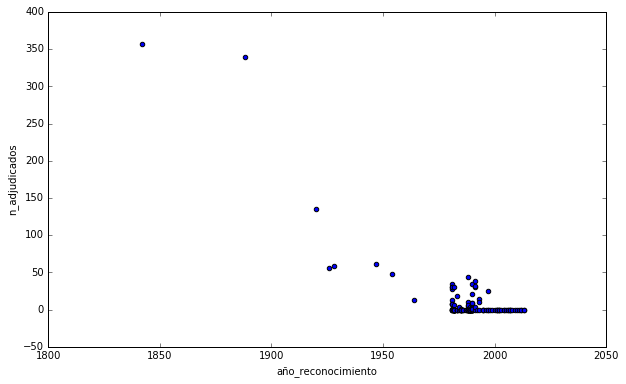

In [33]:
#mineduc_fondecyt.to_csv('data/mineduc_fondecyt_2016.csv', index=True)
fig, ax = plt.subplots(figsize=(10,6))
mineduc.plot(ax=ax, kind='scatter',x='año_reconocimiento',y='n_adjudicados')

In [184]:
mineduc

,tipo,n_registro,nombre,tipo_reconocimiento,documento_reconocimiento,n_documento_reconocimiento,fecha_reconocimiento,regimen_funcionamiento,año_reconocimiento
32,A,1,Universidad de Chile,Creación,Ley,s/n,1842-11-19,Autónoma,1842
48,B,1,Pontificia Universidad Católica de Chile,Fundación,Decreto,S/N,1888-06-21,Autónoma,1888
49,B,2,Universidad de Concepción,Fundación,Decreto Supremo,1038,1920-05-14,Autónoma,1920
50,B,3,Universidad Técnica Federico Santa María,Fundación,Decreto Supremo,996,1926-04-27,Autónoma,1926
51,B,4,Pontificia Universidad Católica de Valparaíso,Creación,Decreto,s/n,1928-03-15,Autónoma,1928
33,A,2,Universidad de Santiago de Chile,Creación,Decreto,1831,1947-09-04,Autónoma,1947
52,B,5,Universidad Austral de Chile,Fundación,Decreto,3757,1954-07-09,Autónoma,1954
53,B,6,Universidad Católica del Norte,Fundación,Ley,"15,561",1964-04-02,Autónoma,1964
0,C,1,Universidad Gabriela Mistral,Autorización de Funcionamiento,Certificado,S/N,1981-01-12,Autónoma,1981
57,D,5,Instituto Profesional Agrario Adolfo Matthei,Autorización de Funcionamiento,Dex.,280,1981-01-12,Autónoma,1981


In [183]:
mineduc_fondecyt=mineduc.copy()
fondecyt_university['nombre_upper']=fondecyt_university.apply(lambda x: x['nombre'].upper(), axis=1)
mineduc_fondecyt['nombre_upper']=mineduc.apply(lambda x: x['nombre'].upper(), axis=1)
mineduc_fondecyt['fondecyt_n_concursados']=0
mineduc_fondecyt['fondecyt_n_adjudicados']=0
mineduc_fondecyt['fondecyt_tasa_adjudicacion']=0.
for i in range(len(fondecyt_university.index)):
    d = mineduc_fondecyt.apply(lambda x: fuzz.ratio(x['nombre_upper'], fondecyt_university.ix[i, 'nombre_upper']), axis=1)
    mineduc_fondecyt.ix[d.idxmax(), 'fondecyt_n_concursados']=fondecyt_university.ix[i,'n_concursados']
    mineduc_fondecyt.ix[d.idxmax(), 'fondecyt_n_adjudicados']=fondecyt_university.ix[i,'n_aprobados']
    mineduc_fondecyt.ix[d.idxmax(), 'fondecyt_tasa_adjudicacion']=np.round(fondecyt_university.ix[i,'n_aprobados']/fondecyt_university.ix[i,'n_concursados']*100,decimals=1)

fondecyt_university.drop('nombre_upper', axis=1, inplace=True)
mineduc_fondecyt.drop('nombre_upper', axis=1, inplace=True)
mineduc_fondecyt.reset_index(inplace=True)
mineduc_fondecyt

,index,tipo,n_registro,nombre,tipo_reconocimiento,documento_reconocimiento,n_documento_reconocimiento,fecha_reconocimiento,regimen_funcionamiento,año_reconocimiento,fondecyt_n_concursados,fondecyt_n_adjudicados,fondecyt_tasa_adjudicacion
0,32,A,1,Universidad de Chile,Creación,Ley,s/n,1842-11-19,Autónoma,1842,880,357,40.6
1,48,B,1,Pontificia Universidad Católica de Chile,Fundación,Decreto,S/N,1888-06-21,Autónoma,1888,695,339,48.8
2,49,B,2,Universidad de Concepción,Fundación,Decreto Supremo,1038,1920-05-14,Autónoma,1920,364,135,37.1
3,50,B,3,Universidad Técnica Federico Santa María,Fundación,Decreto Supremo,996,1926-04-27,Autónoma,1926,139,56,40.3
4,51,B,4,Pontificia Universidad Católica de Valparaíso,Creación,Decreto,s/n,1928-03-15,Autónoma,1928,162,59,36.4
5,33,A,2,Universidad de Santiago de Chile,Creación,Decreto,1831,1947-09-04,Autónoma,1947,167,61,36.5
6,52,B,5,Universidad Austral de Chile,Fundación,Decreto,3757,1954-07-09,Autónoma,1954,142,48,33.8
7,53,B,6,Universidad Católica del Norte,Fundación,Ley,"15,561",1964-04-02,Autónoma,1964,60,13,21.7
8,0,C,1,Universidad Gabriela Mistral,Autorización de Funcionamiento,Certificado,S/N,1981-01-12,Autónoma,1981,0,0,0.0
9,57,D,5,Instituto Profesional Agrario Adolfo Matthei,Autorización de Funcionamiento,Dex.,280,1981-01-12,Autónoma,1981,0,0,0.0


In [211]:
def get_fondecyt(row):
    d = fondecyt_university.apply(lambda x: fuzz.ratio(x['nombre'].capitalize(), row['nombre'].capitalize()), axis=1)
    d = d[d >= 80]
    if len(d) == 0:
        v = ['']*4
    else:
        v = np.append(fondecyt_university.ix[d.idxmax(), ['nombre','n_concursados','n_aprobados']].values, d.max())
        
    return pd.Series(v, index=['fondecyt_nombre','n_concursados','n_aprobados','fuzz_ratio'])

def get_mineduc(row):
    d = mineduc.apply(lambda x: fuzz.ratio(x['nombre'].capitalize(), row['nombre'].capitalize()), axis=1)
    print(type(row), row)
    print(type(d))
    d = d[d >= 80]
    if len(d) == 0:
        v = ['']*2
    else:
        v = np.append(mineduc.ix[d.idxmax(), ['nombre']].values, d.max())
        
    return pd.Series(v, index=['mineduc_nombre','fuzz_ratio'])

def match_mineduc(row):
    d = mineduc.apply(lambda x: fuzz.ratio(x['nombre'].capitalize(), row['nombre'].capitalize()), axis=1)
    d = d[d >= 80]
    if len(d) == 0:
        v = ['']*4
    else:
        v = np.append(mineduc.ix[d.idxmax(), ['nombre']].values, row[['n_concursados','n_aprobados']], d.max())
        
    return pd.Series(v)

#pd.concat( (ies,ies.apply(get_fondecyt, axis=1)), axis=1)[['nombre','fondecyt_nombre','fuzz_ratio']]
fondecyt_mineduc_university=pd.concat( (fondecyt_university,fondecyt_university.apply(get_mineduc, axis=1)), axis=1)
fondecyt_mineduc_university.head()
#fondecyt_university.apply(match_mineduc, axis=1)

<class 'pandas.core.series.Series'> nombre           Universidad de chile
n_concursados                     880
n_aprobados                       357
nombre_upper     UNIVERSIDAD DE CHILE
Name: 0, dtype: object
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'> nombre           Universidad de chile
n_concursados                     880
n_aprobados                       357
nombre_upper     UNIVERSIDAD DE CHILE
Name: 0, dtype: object
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'> nombre           Pontificia universidad catolica de chile
n_concursados                                         695
n_aprobados                                           339
nombre_upper     PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE
Name: 1, dtype: object
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'> nombre           Universidad de concepcion
n_concursados                          364
n_aprobados                            135
nombre_upper  

,nombre,n_concursados,n_aprobados,nombre_upper,mineduc_nombre,fuzz_ratio
0,Universidad de chile,880,357,UNIVERSIDAD DE CHILE,Universidad de Chile,100
1,Pontificia universidad catolica de chile,695,339,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,Pontificia Universidad Católica de Chile,98
2,Universidad de concepcion,364,135,UNIVERSIDAD DE CONCEPCION,Universidad de Concepción,96
3,Universidad de santiago de chile,167,61,UNIVERSIDAD DE SANTIAGO DE CHILE,Universidad de Santiago de Chile,100
4,Pontificia universidad catolica de valparaiso,162,59,PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,Pontificia Universidad Católica de Valparaíso,96


In [192]:
#pd.merge(mineduc,fondecyt_mineduc_university,how='outer',left_on='nombre',right_on='mineduc_nombre')
mineduc['nombre'].values

array(['Universidad de Chile', 'Pontificia Universidad Católica de Chile',
       'Universidad de Concepción',
       'Universidad Técnica Federico Santa María',
       'Pontificia Universidad Católica de Valparaíso',
       'Universidad de Santiago de Chile', 'Universidad Austral de Chile',
       'Universidad Católica del Norte', 'Universidad Gabriela Mistral',
       'Instituto Profesional Agrario Adolfo Matthei',
       'Universidad de Talca', 'Universidad de Magallanes',
       'Universidad de Atacama', 'Universidad de Valparaíso',
       'Universidad del Bío-Bío', 'Universidad de La Serena',
       'Universidad de Antofagasta', 'Universidad de La Frontera',
       'Instituto Profesional INACAP o Instituto Profesional Instituto Nacional de Capacitación Profesional INACAP',
       'Universidad de Tarapacá',
       'Instituto Profesional Libertador de Los Andes',
       'Universidad Finis Terrae',
       'Centro de Formación Técnica de ENAC o Centro de Formación Técnica de los Estab

In [191]:
fondecyt_university['nombre_uppercase']=fondecyt_university['nombre'].apply(lambda x: x.capitalize())
mineduc['nombre_uppercase']=mineduc['nombre'].apply(lambda x: x.capitalize())
#mineduc['fondecyt_n_aprobados']=np.nan
for i in range(len(fondecyt_university.index)):
    d=fuzz.ratio( fondecyt_university.ix[i,'nombre'].capitalize(), mineduc['nombre'].values.capitalize())
    print(fondecyt_university.ix[i,'nombre'], mineduc.ix[d.idxmax(), 'nombre'])

AttributeError: 'numpy.ndarray' object has no attribute 'capitalize'

In [7]:
fondecyt_university=fondecyt.groupby(['nombre']).sum().sort_values('n_aprobados', ascending=False)
fondecyt_university.to_csv('FONDECYT_universidades', index=False)

In [61]:
fondecyt_2014.head()

,nombre,n_concursados,n_aprobados,año
0,UNIV. DE CHILE,253,125,2014
1,PONT. UNIV. CATOLICA DE CHILE,202,118,2014
2,UNIV. DE CONCEPCION,108,46,2014
3,UNIV. DE SANTIAGO DE CHILE,74,33,2014
4,PONT. UNIV. CATOLICA DE VALPARAISO,69,31,2014


In [62]:
fondecyt_2015.head()

,nombre,n_concursados,n_aprobados,año
0,UNIV. DE CHILE,289,123,2015
1,PONT. UNIV. CATOLICA DE CHILE,225,108,2015
2,UNIV. DE CONCEPCION,112,46,2015
3,PONT. UNIV. CATOLICA DE VALPARAISO,2,1,2015
4,UNIV. TECNICA FEDERICO SANTA MARIA,40,18,2015


In [63]:
fondecyt_2016.head()

,nombre,n_concursados,n_aprobados,año
0,PONT. UNIV. CATOLICA DE CHILE,268,113,2016
1,UNIV. DE CHILE,338,109,2016
2,UNIV. DE CONCEPCION,144,43,2016
3,PONT. UNIV. CATOLICA DE VALPARAISO,91,27,2016
4,UNIV. DE SANTIAGO DE CHILE,92,27,2016


In [142]:
fondecyt_university_year=fondecyt.groupby(['nombre','año']).sum()  #.sort_values('n_aprobados',ascending=False)[['n_concursados','n_aprobados']]
fondecyt_university_year['tasa_aprobacion']=np.round(fondecyt_university_year['n_aprobados']/fondecyt_university['n_concursados']*100.,decimals=1)
fondecyt_university_year
#fondecyt_university_year=fondecyt_university_year.round({'tasa_aprobacion':1})

#fondecyt_university_year#.reset_index()
#fondecyt_university_year.sort_values('n_aprobados',ascending=False)

n_concursados  n_aprobados  \
nombre                                     año                                
PONT. UNIV. CATOLICA DE CHILE              2014            202          118   
                                           2015            225          108   
                                           2016            268          113   
PONT. UNIV. CATOLICA DE VALPARAISO         2014             69           31   
                                           2015              2            1   
                                           2016             91           27   
UNIV. ACADEMIA DE HUMANISMO CRISTIANO      2014              9            2   
                                           2015              4            1   
                                           2016              7            2   
UNIV. ADOLFO IBANEZ                        2015              0            0   
                                           2016             33            4   
UNIV. ADOLFO IBAÑEZ                       2014             14            4   
UNIV. ADVENTISTA DE CHILE                  2015              6            1   
UNIV. ALBERTO HURTADO                      2014             22           16   
                                           2015             14            2   
                                           2016             17            7   
UNIV. ANDRES BELLO                         2014             36           19   
                                           2015             15            5   
                                           2016             60           20   
UNIV. ARTES Y CIENCIAS SOCIALES            2014              3            0   
                                           2015              2            1   
UNIV. ARTURO PRAT                          2014              4            2   
                                           2015              7            0   
                                           2016              3            1   
UNIV. AUSTRAL DE CHILE                     2014             49           22   
                                           2015             22            5   
                                           2016             71           21   
UNIV. AUTONOMA DE CHILE                    2014             12            4   
                                           2015              1            0   
                                           2016             26            2   
UNIV. BERNARDO O'HIGGINS                   2014              3            1   
                                           2015              1            0   
                                           2016              7            1   
UNIV. CATOLICA CARDENAL SILVA HENRIQUEZ    2014              2            1   
                                           2015             16            3   
                                           2016              4            0   
UNIV. CATOLICA DE LA STMA. CONCEPCION      2014              6            2   
                                           2015             77           31   
                                           2016              9            5   
UNIV. CATOLICA DE TEMUCO                   2014             19            4   
                                           2015             50           24   
                                           2016             22            3   
UNIV. CATOLICA DEL MAULE                   2014             15            1   
                                           2015             68           30   
                                           2016             13            1   
UNIV. CATOLICA DEL NORTE                   2014             21            8   
                                           2015              6            1   
                                           2016             33            4   
UNIV. CENTRAL DE CHILE                     2014              9            2   
                     

In [155]:
#fondecyt['tasa_aprobacion']=fondecyt['n_aprobados']/fondecyt['n_concursados']*100.
#fondecyt=fondecyt.round({'tasa_aprobacion':1})
table = pd.pivot_table(fondecyt,values=['n_concursados','n_aprobados'],index=['nombre'],columns=['año'],aggfunc=np.sum,margins=True)
#table = table.round({'tasa_aprobacion':1})
table.sort_values(by=('n_aprobados','All'), ascending=False,inplace=True)
table.reset_index( inplace=True)
table
#.stack('año')
#table=table.reset_index()
#table.loc[0]['tasa_aprobacion']=table.loc[0]['n_aprobados']
#print(np.round(table['n_aprobados']['All']/table['n_concursados']['All']*100.,1))
#table.stack('año')
#tble
#table['test']=table['2014']/table['2015']
##table['tasa_aprobacion']=table['n_aprobados']/table['n_concursados']*100.
##table.stack('año').sort_values(by=('n_aprobados'), ascending=False,inplace=True)
#table.reset_index()
#table#.query('n_concursados > n_aprobados')

nombre n_concursados                  \
año                                                      2014    2015    2016   
0                                           All        1250.0  1453.0  1698.0   
1                                UNIV. DE CHILE         253.0   289.0   338.0   
2                 PONT. UNIV. CATOLICA DE CHILE         202.0   225.0   268.0   
3                           UNIV. DE CONCEPCION         108.0   112.0   144.0   
4                    UNIV. DE SANTIAGO DE CHILE          74.0     1.0    92.0   
5            PONT. UNIV. CATOLICA DE VALPARAISO          69.0     2.0    91.0   
6            UNIV. TECNICA FEDERICO SANTA MARIA          36.0    40.0    63.0   
7                        UNIV. AUSTRAL DE CHILE          49.0    22.0    71.0   
8                            UNIV. ANDRES BELLO          36.0    15.0    60.0   
9         UNIV. CATOLICA DE LA STMA. CONCEPCION           6.0    77.0     9.0   
10                               UNIV. DE TALCA          33.0    18.0    55.0   
11                          UNIV. SAN SEBASTIAN           1.0    70.0     3.0   
12                     UNIV. CATOLICA DEL MAULE          15.0    68.0    13.0   
13                         UNIV. DE LA FRONTERA          29.0    28.0    46.0   
14                     UNIV. CATOLICA DE TEMUCO          19.0    50.0    22.0   
15                            UNIV. DEL BIO-BIO          25.0    39.0    42.0   
16                         UNIV. DIEGO PORTALES          41.0     6.0    40.0   
17                          UNIV. DE VALPARAISO          33.0    11.0    41.0   
18                        UNIV. ALBERTO HURTADO          22.0    14.0    17.0   
19                           UNIV. DE LOS ANDES          26.0     4.0    31.0   
20                       UNIV. CENTRAL DE CHILE           9.0    34.0     3.0   
21                           UNIV. VINA DEL MAR           NaN    49.0     NaN   
22                           UNIV. DE LOS LAGOS          11.0    37.0    12.0   
23                     UNIV. CATOLICA DEL NORTE          21.0     6.0    33.0   
24                           UNIV. DE LA SERENA          11.0     5.0    19.0   
25              UNIV. TECNOLOGICA METROPOLITANA           1.0    33.0     2.0   
26                                  UNIV. MAYOR           3.0    17.0     4.0   
27                         UNIV. DEL DESARROLLO          18.0     1.0    18.0   
28                           UNIV. DEL PACIFICO           1.0    18.0     2.0   
29                         UNIV. DE ANTOFAGASTA          14.0     3.0    17.0   
30                            UNIV. DE TARAPACA          10.0    10.0    23.0   
31                          UNIV. DE MAGALLANES           8.0     5.0     8.0   
32                           UNIV. FINIS TERRAE           2.0    48.0     1.0   
33                            UNIV. SANTO TOMAS           2.0    17.0     4.0   
34                      UNIV. AUTONOMA DE CHILE          12.0     1.0    26.0   
35        UNIV. ACADEMIA DE HUMANISMO CRISTIANO           9.0     4.0     7.0   
36    UNIV. METROPOLITANA DE CS.DE LA EDUCACION           NaN    30.0    10.0   
37                          UNIV. ADOLFO IBANEZ           NaN     0.0    33.0   
38                         UNIV. ADOLFO IBAÑEZ          14.0     NaN     NaN   
39      UNIV. CATOLICA CARDENAL SILVA HENRIQUEZ           2.0    16.0     4.0   
40                            UNIV. ARTURO PRAT           4.0     7.0     3.0   
41                     UNIV. BERNARDO O'HIGGINS           3.0     1.0     7.0   
42           UNIV. DE PLAYA ANCHA CS. EDUCACION           8.0     6.0    11.0   
43                             UNIV. DE ATACAMA           1.0     5.0     5.0   
44              UNIV. ARTES Y CIENCIAS SOCIALES           3.0     2.0     NaN   
45                    UNIV. ADVENTISTA DE CHILE           NaN     6.0     NaN   
46       UNIV. IBEROAMERICANA DE CIENCIA Y TEC.           NaN     NaN     0.0   
47                        UNIV. DE LA REPUBLICA           0.0     NaN    

In [153]:

#pd.merge(table, table['n_aprobados']/table['n_concursados'], 'left',on=[])

/usr/local/lib/python3.5/site-packages/pandas/tools/merge.py:205: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


MergeError: No common columns to perform merge on

In [137]:
h = HTML(table.stack('año').to_html())
h

my_file = open('tabla_fondecyt_regular_2014-2016.html', 'w')
my_file.write(h.data)
my_file.close()

In [141]:
fondecyt_university=fondecyt.groupby('nombre').sum().sort_values('n_aprobados',ascending=False)[['n_concursados','n_aprobados']]
fondecyt_university['tasa_aprobacion']=fondecyt_university['n_aprobados']/fondecyt_university['n_concursados']*100.
fondecyt_university=fondecyt_university.round({'tasa_aprobacion':1})

fondecyt_university.sort_values('n_aprobados',ascending=False)

,n_concursados,n_aprobados,tasa_aprobacion
nombre,,,
UNIV. DE CHILE,880,357,40.6
PONT. UNIV. CATOLICA DE CHILE,695,339,48.8
UNIV. DE CONCEPCION,364,135,37.1
UNIV. DE SANTIAGO DE CHILE,167,61,36.5
PONT. UNIV. CATOLICA DE VALPARAISO,162,59,36.4
UNIV. TECNICA FEDERICO SANTA MARIA,139,56,40.3
UNIV. AUSTRAL DE CHILE,142,48,33.8
UNIV. ANDRES BELLO,111,44,39.6
UNIV. CATOLICA DE LA STMA. CONCEPCION,92,38,41.3
